**Import Libraries**

In [34]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [35]:
import os
import zipfile
from glob import glob

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2

# Machine Learning Libraries
from torchvision import transforms

# **Step 1: Load Data**

In [36]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

In [37]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [38]:
# Define Disease Labels
disease_labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].apply(lambda x: 1 if 'No finding' in x else 0)

    # Map image filenames to their full paths
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(image_path, 'train', f"{x}.dicom"))
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [39]:
labels_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,Aortic enlargement,Atelectasis,...,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,Path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,0,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Patients Training Set**

In [40]:
unique_patients = labels_df['image_id'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 15000


**Number of Images with Abnormalities Training Set**

In [41]:
labels_abnormalities_df = labels_df[labels_df['class_id'] != 14]
num_abnormalities = labels_abnormalities_df['Path'].unique()
print("Number of Images with abnormalities:",len(num_abnormalities))

Number of Images with abnormalities: 4394


**Distribution of Disease Label Training Set**

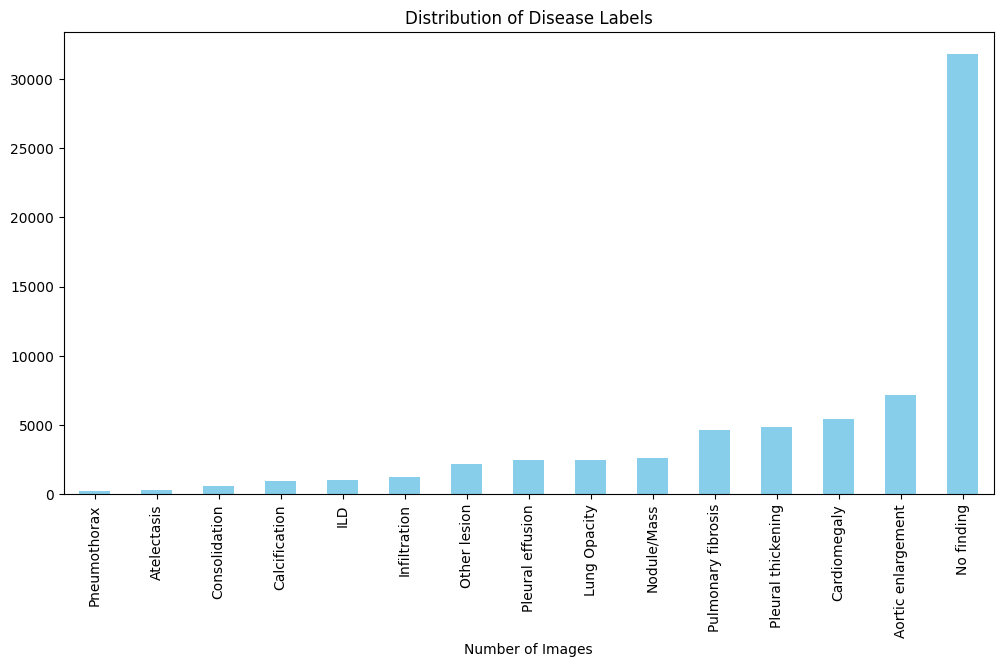

In [42]:
# Retrive the disease labels + "No finding" from dataframe
labels = labels_df[disease_labels + ['No finding']]

# Sum each label
counted_labels = labels.sum()

# Sort in descending order
counted_labels = counted_labels.sort_values()

# Plotting from the counted_labels
plt.figure(figsize=(12, 6))
counted_labels.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Images')
plt.title('Distribution of Disease Labels')
plt.show()

**Visualize Samples with Bounding Boxes**

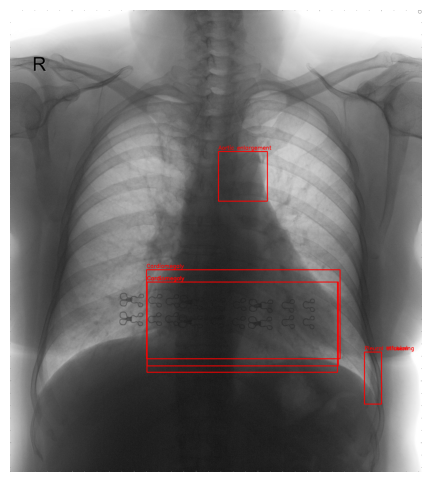

In [43]:
# Path to the first DICOM sample
img_path = labels_df['Path'].iloc[2]

# Read the DICOM file using pydicom
ds = pydicom.dcmread(img_path)
img = ds.pixel_array

if img.dtype != np.uint8:
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img.astype(np.uint8)

img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

rows = labels_df[labels_df['Path'] == img_path]

# Define box drawing settings
thickness = 3
box_color = (0, 0, 255)

# Loop over each bounding box for the image
for _, row in rows.iterrows():

    if not np.isnan(row['x_min']):
        x_min = int(row['x_min'])
        y_min = int(row['y_min'])
        x_max = int(row['x_max'])
        y_max = int(row['y_max'])
        
        cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), box_color, thickness)
        
        cv2.putText(img_color, row['class_name'], (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, box_color, 2)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# **Step 4: Explore Image Preprocessing and Augmentation Techniques**

In [44]:
# TODO